In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"; 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

In [5]:
import numpy as np
import keras
import cv2 as cv
from sklearn.metrics import f1_score

Using TensorFlow backend.


In [6]:
from models.SegNet import seg_net
from models.segnet_seq import SegNet
from keras.preprocessing.image import load_img
from keras.utils.np_utils import to_categorical  
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

In [7]:
import tensorflow as tf
#tf.enable_eager_execution()

In [5]:
import keras.backend as K

In [6]:
from PIL import Image

In [8]:
def load_image(path, mask=False, shape=(256,256)):
    if mask:
        img = cv.imread(path, 0)
        img = cv.resize(img, shape, interpolation = cv.INTER_NEAREST)
    else:
        img = cv.imread(path) / 255.0
        img = cv.resize(img, shape, interpolation = cv.INTER_AREA)
    return img

In [8]:
def replace_ext(path):
    return path[:-4] + '.jpg'

In [1]:
def draw_results(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('steps')
    plt.legend(['val', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('steps')
    plt.legend(['val', 'test'], loc='upper left')
    plt.show()

In [9]:
def get_weights(data):
    #print(data.shape)
    num_img , width_height = data.shape
    constant = 1 / 46
    weights = np.zeros((num_img , width_height)) + ( constant / 47)
    #print(weights.shape)
    rows, cols = np.where(data != 0)
    for row in rows:
        for col in cols: 
            weights[row, col] = constant
            
    return weights

In [10]:
def generateData( labels , batch_size = 1 , train_path = './_train/',
                train_label_path = './masks/', img_w = 256, img_h = 256, n_classes = 47):  

    while True:  
        train_data = []  
        train_label = []  
        batch = 0  
        for i in (range(len(labels))): 
            uri = labels[i]
            batch += 1 
            img = load_image(replace_ext(train_path + uri))
            train_data.append(img)  
            mask = load_image(train_label_path + uri, True)
            mask = mask.reshape((img_w * img_h,))  
            train_label.append(mask)  
            
            
            if batch % batch_size == 0: 
                train_data = np.array(train_data)  
                #weights = get_weights(np.array(train_label))
                train_label = np.array(train_label)#.flatten()
                train_label = to_categorical(train_label, num_classes= n_classes)  
                train_label = train_label.reshape( ( batch_size, img_w * img_h , n_classes ) )  
                yield (train_data,train_label)
                train_data = []  
                train_label = []  
                batch = 0  

In [11]:
model = SegNet((256,256) , n_label=47)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model = model.get_model()

In [11]:
def myLoss(onehot_labels, logits):
    print(onehot_labels.shape, logits.shape)
    constant = 1 / 47
    _weigths = [constant] * 47 
    _weigths[0] =  constant / 47
    class_weights = tf.constant(_weigths)
    # deduce weights for batch samples based on their true label
    weights = tf.reduce_sum(class_weights * onehot_labels, axis=1)
    # compute your (unweighted) softmax cross entropy loss
    unweighted_losses = tf.nn.softmax_cross_entropy_with_logits(labels= onehot_labels, logits = [logits])
    # apply the weights, relying on broadcasting of the multiplication
    weighted_losses = unweighted_losses * weights
    # reduce the result to get your final loss
    loss = tf.reduce_mean(weighted_losses)

In [12]:
def generalized_dice_loss(labels, logits):

    smooth = 1e-17
    shape = tf.TensorShape(logits.shape).as_list()
    depth = int(shape[-1])
    #labels = tf.one_hot(labels, depth, dtype=tf.float32)
    #logits = tf.nn.softmax(logits)
    weights = 1.0 / (tf.reduce_sum(labels, axis=[0, 1, 2])**2)
    print(weights.shape)
    numerator = tf.reduce_sum(labels * logits, axis=[0, 1, 2])
    numerator = tf.reduce_sum(weights * numerator)

    denominator = tf.reduce_sum(labels + logits, axis=[0, 1, 2])
    denominator = tf.reduce_sum(weights * denominator)

    loss = 1.0 - 2.0*(numerator + smooth)/(denominator + smooth)
    return loss

In [13]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)


        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [14]:
labels = os.listdir('./masks/')

In [18]:
_w = 0.4 + np.zeros((1,1,47))
_w[0,0,0] = 0.1
one_image = load_image('masks/' + labels[1], mask=True)
unique, counts = np.unique(one_image, return_counts=True)
unique , counts
size = len(one_image.reshape(-1,1))
1 - (counts / size)

/opt/anaconda3/envs/fashion/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


array([0.14855957, 0.90966797, 0.95491028, 0.99937439, 0.98748779])

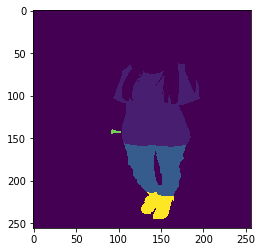

In [77]:
plt.imshow(one_image)

In [16]:
def my_loss_ultimatum(y_true, y_fake, gamma=2):
    #x = tf.nn.softmax_cross_entropy_with_logits(labels = y_true, logits= y_fake)
    #return x
    """
    loss = y_true * tf.log(y_fake)
    loss = loss * _w
    loss = -tf.reduce_sum(loss)
    return loss
    """
    
    return -tf.reduce_sum(K.pow(1. - y_fake, gamma) * y_true * K.log(y_fake))
    
    
    

In [17]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [218]:
#optimizer = Adam(lr=0.004)
model.compile(loss='categorical_crossentropy' ,optimizer='adam',metrics=['accuracy' , f1 ])#, f1_score])# sample_weight_mode="temporal")
model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 128)     512       
__________

In [219]:
csv_logger = CSVLogger('training.log')
check_point = ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5')

In [223]:
history = model.fit_generator(generateData(labels[32:33] , batch_size = 1),
                    steps_per_epoch= 100,
                    validation_data= generateData(labels[32:33]),
                    validation_steps= 1,
                    epochs = 5,
                    callbacks = [csv_logger, check_point])

Epoch 1/5


/opt/anaconda3/envs/fashion/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


100/100 [==============================] - 40s 403ms/step - loss: 0.1555 - acc: 0.9247 - f1: 0.0197 - val_loss: 0.6872 - val_acc: 0.8629 - val_f1: 0.0183
Epoch 2/5
100/100 [==============================] - 30s 304ms/step - loss: 0.0227 - acc: 0.9922 - f1: 0.0211 - val_loss: 0.6863 - val_acc: 0.8713 - val_f1: 0.0185
Epoch 3/5
100/100 [==============================] - 30s 303ms/step - loss: 0.0115 - acc: 0.9966 - f1: 0.0212 - val_loss: 0.6670 - val_acc: 0.8860 - val_f1: 0.0188
Epoch 4/5
100/100 [==============================] - 30s 304ms/step - loss: 0.0094 - acc: 0.9971 - f1: 0.0212 - val_loss: 0.1543 - val_acc: 0.9648 - val_f1: 0.0205
Epoch 5/5
100/100 [==============================] - 30s 304ms/step - loss: 0.0027 - acc: 0.9997 - f1: 0.0213 - val_loss: 0.0896 - val_acc: 0.9794 - val_f1: 0.0208


dict_keys(['val_loss', 'val_acc', 'val_f1', 'loss', 'acc', 'f1'])


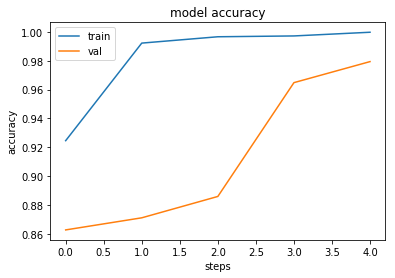

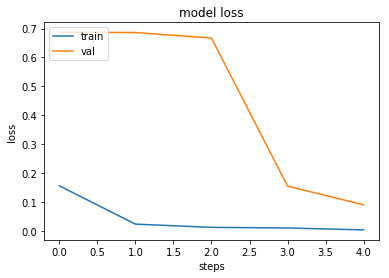

In [224]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [18]:
from models.Unet import Unet

In [19]:
unet_model = Unet(n_label=47, input_size=(256,256,3))
unet_model = unet_model.get_model()
unet_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxP

/home/hcastro/moda_dataset/models/Unet.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  self.model = Model(input = inputs, output = reshaped)


In [22]:
#optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

In [22]:
unet_model.compile(loss=my_loss_ultimatum ,optimizer='adam',metrics=['accuracy' , f1] )  

In [23]:
history = unet_model.fit_generator(generateData(labels[:1] , batch_size = 1), 
                    steps_per_epoch=100,
                    validation_data= generateData(labels[:1]),
                    validation_steps= 1,
                    epochs = 5)
                    #callbacks = [csv_logger, check_point])

Epoch 1/5


/opt/anaconda3/envs/fashion/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


100/100 [==============================] - 31s 305ms/step - loss: nan - acc: 0.0089 - f1: 0.0213 - val_loss: 8453.5176 - val_acc: 0.0000e+00 - val_f1: 0.0213
Epoch 2/5
100/100 [==============================] - 27s 268ms/step - loss: 7787.9501 - acc: 0.0000e+00 - f1: 0.0213 - val_loss: 7153.6289 - val_acc: 0.0000e+00 - val_f1: 0.0213
Epoch 3/5
100/100 [==============================] - 27s 268ms/step - loss: 6610.0654 - acc: 0.0000e+00 - f1: 0.0213 - val_loss: 6091.0786 - val_acc: 0.0000e+00 - val_f1: 0.0213
Epoch 4/5
100/100 [==============================] - 26s 263ms/step - loss: 5644.8441 - acc: 0.0000e+00 - f1: 0.0213 - val_loss: 5218.0698 - val_acc: 0.0000e+00 - val_f1: 0.0213
Epoch 5/5
100/100 [==============================] - 26s 261ms/step - loss: 4849.8446 - acc: 0.0000e+00 - f1: 0.0213 - val_loss: 4497.0410 - val_acc: 0.0000e+00 - val_f1: 0.0213


In [2]:
def predict_one_image(path):
    img = load_image(path)
    batch_p = np.zeros((1,256,256,3))
    batch_p[0] = img
    pred = model.predict(batch_p)
    max_ = np.argmax(pred[0], axis = 1)
    final_img = max_.reshape(256,256)
    plt.imshow(final_img)

In [ ]:
predict_one_image("_train" + os.sep +  replace_ext(labels[32]))